# Hindcast 2019-05 Jun-Aug anomalies

This notebook contains the processing code to plot hindcast 2019-05 anomalies over the 2015-2019 record.

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt, dates
from windrose import WindroseAxes
from cmocean import cm as cmo
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

### Processing

Load fields from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
slc = {'y': slice(334, 790), 'x': slice(114, 390)}
e3t, tmask = [mask[var].isel(**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2015, 2020), ['salinity', 'nitrate', 'diatoms', 'ciliates', 'flagellates']

# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in tqdm(years):
    
    # Initialize lists
    for var in variables: data[var] = []
    
    # Load monthly averages
    for month in range(6, 9):
        datestr = f'{year}{month:02d}'
        prefix = f'/results/SalishSea/month-avg.201905/SalishSea_1m_{datestr}_{datestr}'
        
        # Load salinity
        with xr.open_dataset(prefix + '_grid_T.nc') as ds:
            data['salinity'].append(ds.vosaline.isel(deptht=0, **slc).values)
        
        # Load ecosystem variables
        with xr.open_dataset(prefix + '_ptrc_T.nc') as ds:
            data['nitrate'].append(ds.nitrate.isel(deptht=0, **slc).values)
            for var in ['diatoms', 'ciliates', 'flagellates']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add chlorophyll fields
aggregates['chlorophyll'] = {}
variables.append('chlorophyll')
for year in years:
    aggregates['chlorophyll'][year] = sum(aggregates[var][year] for var in ['diatoms', 'ciliates', 'flagellates'])

# Calculate 5 year mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

  0%|          | 0/5 [00:00<?, ?it/s]

Load HRDPS wind

In [4]:
# Load wind from pre-aggregated .nc file
HRDPS = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/HRDPS_1h_20141201_20200201_wind.nc')
time = HRDPS.time.values.astype('datetime64[s]').astype(datetime)
windmask = HRDPS.landmask.values
waterpoints = np.copy(windmask)
waterpoints[:40, :] = 0
waterpoints[100:, :] = 0
waterpoints[:, 60:] = 0
waterpoints = waterpoints.ravel().astype(bool)
u, v = [HRDPS[var].values for var in ('u_wind', 'v_wind')]
wspd = np.sqrt(u**2 + v**2)
wdir = 270 - np.rad2deg(np.arctan2(v, u))
wdir[wdir < 0] = wdir[wdir < 0] + 360

# Compiles summer averages
wind = {}
for key in ['wspd', 'wdir']:
    wind[key] = {}
    aggregates[key] = {}
for year in years:
    index = (time > datetime(year, 6, 1)) & (time < datetime(year, 9, 1))
    for var, key in zip([wspd, wdir], ['wspd', 'wdir']):
        wind[key][year] = var[index].reshape(-1, 10400)[:, waterpoints].mean(axis=1)
        aggregates[key][year] = var[index].mean(axis=0)

# Find 5 year mean and yearly anomalies
for key in ('wspd', 'wdir'):
    aggregates[key]['mean'] = np.concatenate([aggregates[key][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[key][year] = aggregates[key][year] - aggregates[key]['mean']

In [5]:
# Reset variables for plotting
tmask = tmask[0, 0, ...]
variables = ['wspd', 'salinity', 'nitrate', 'chlorophyll']

***

### Plotting

Plot seasonal averages

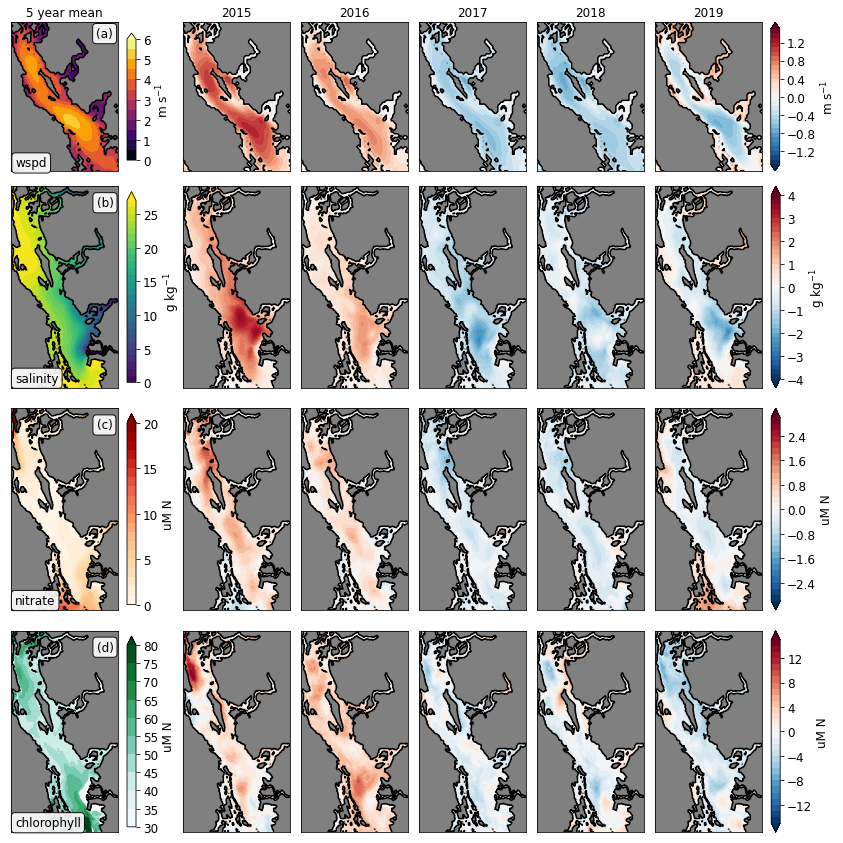

In [15]:
gridspec_kw = {'height_ratios': [0.7, 1, 1, 1], 'wspace': 0.1, 'hspace': 0.05}
fig, axs = plt.subplots(4, 6, figsize=(12.5, 15), gridspec_kw=gridspec_kw)

cmaps = ['inferno', 'viridis', 'OrRd', 'BuGn']
units = ['m s$^{-1}$', 'g kg$^{-1}$', 'uM N', 'uM N']
clims = [(0, 6.1, 0.5), (0, 28, 1), (0, 21, 1), (30, 80.1, 5)]
dclims = [(-1.5, 1.6, 0.1), (-4, 4.1, 0.2), (-3, 3.1, 0.2), (-15, 15.1, 1)]
for row, var, unit, cmap, clim, dclim, dcbar in zip(axs, variables, units, cmaps, clims, dclims, [1, 5, 5, 5, 5]):
    
    c = row[0].contourf(aggregates[var]['mean'], levels=np.arange(*clim), cmap=cmap, extend='max')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.06, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.05, pos.y0+0.01, 0.01, pos.height-0.02])
    fig.colorbar(c, cax=cax, ticks=np.arange(*clim[:2], dcbar), label=unit)
    row[0].text(0.04, 0.03, var, transform=row[0].transAxes, bbox={'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9})
    if var == 'wspd': row[0].set_title('5 year mean', fontsize=12)
    
    for ax, year in zip(row[1:], years):
    
        c = ax.contourf(aggregates[var][year], levels=np.arange(*dclim), cmap='RdBu_r', extend='both')
        if var == 'wspd': ax.set_title(year, fontsize=12)
    
    for ax in row:
        if var == 'wspd':
            landmask = windmask
            ax.set_xlim([5, 70])
            ax.set_ylim([30, 110])
        else:
            landmask = tmask
        ax.contourf(landmask, levels=[-0.01, 0.01], colors='gray')
        ax.contour(landmask, levels=[-0.01, 0.01], colors='k')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.set_aspect(5/4.4)
    
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax, label=unit)

for k, row in enumerate(axs):
    row[0].text(0.8, 0.9, f'({chr(97+k)})', transform=row[0].transAxes, bbox={'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9})
    
#fig.savefig('/home/bmoorema/Desktop/upwelling_processes_figs/interannual1.pdf', bbox_inches='tight')

***

### Other plots

In [257]:
# Load NCEI PDO record
df = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat', skiprows=1, index_col=0, delim_whitespace=True)
date, PDO = [], []
for year in range(2005, 2020):
    for month in range(1, 13):
        index = df.index == year
        date.append(datetime(year, month, 1))
        PDO.append(float(df[month_name[month][:3].capitalize()][index]))
date = np.array(date)
PDO = np.array(PDO)

# Quick load Fraser hydrograph (if needed)
Fraser = {}
data = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][1].flatten()
Fraser['date'] = np.array([
    datetime.fromordinal(int(mtime)) +
    timedelta(days=float(mtime)%1) - timedelta(days=366)
    for mtime in data['fraser'][0][0][0]
])

# Plotting attributes
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]

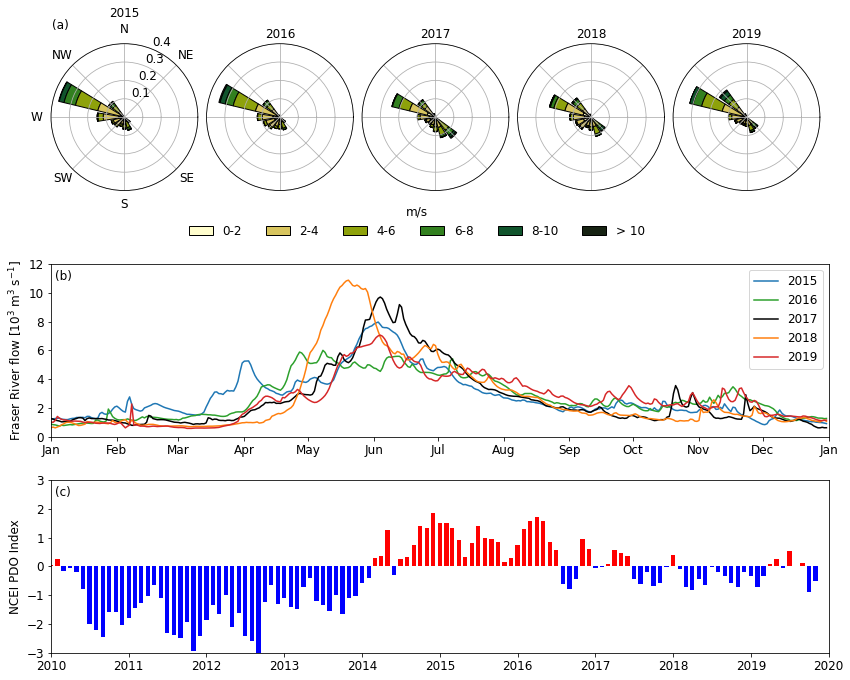

In [285]:
# Make figure
fig = plt.figure(figsize=(12, 12))

for xpos, year in zip(np.arange(0.05, 1, 0.18), range(2015, 2020)):    
    
    # Make windrose object
    ax = WindroseAxes.from_ax(fig=fig)
    ax.set_position([xpos, 0.55, 0.17, 0.24])
    ax.bar(
        wind['wdir'][year], wind['wspd'][year], bins=range(0, 11, 2),
        nsector=16, normed=True, opening=0.8, edgecolor='k', cmap=cmo.speed,
    )

    # Manually get legend handles (since WindroseAxes.bar returns None)
    handles = ax.get_children()[:6]

    # Formatting axis
    ax.set_ylim([0, 40])
    ax.yaxis.set_ticks([10, 20, 30, 40])
    ax.yaxis.set_ticklabels('')
    ax.xaxis.set_ticklabels('')
    ax.set_title(year)
    if year == 2015:
        ax.text(0.01, 1.1, '(a)', transform=ax.transAxes)
        ax.xaxis.set_ticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
        ax.yaxis.set_ticklabels([f'{tick/100:.1f}' for tick in [10, 20, 30, 40]])

# Add legend
labels = ['0-2', '2-4', '4-6', '6-8', '8-10', '> 10']
fig.legend(frameon=False, handles=handles, labels=labels, bbox_to_anchor=(0.75, 0.58), ncol=6, title='m/s')

# Plot Fraser hydrograph
ax = fig.add_axes([0.05, 0.3, 0.9, 0.2])
for year, color in zip(range(2015, 2020), palette):
    index = [datetime(year, 1, 1) <= t < datetime(year+1, 1, 1) for t in Fraser['date']]
    x = [datetime(2020, t.month, t.day) for t in Fraser['date'][index]]
    ax.plot(x, 1e-3*Fraser['flow'][index], color=color, label=year)
ax.set_xlim([datetime(2020, 1, 1), datetime(2021, 1, 1)])
ax.set_ylim([0, 12])
ax.set_ylabel('Fraser River flow [10$^3$ m$^3$ s$^{-1}$]')
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
ax.text(0.005, 0.91, '(b)', transform=ax.transAxes)
ax.legend()

# Plot PDO
ax = fig.add_axes([0.05, 0.05, 0.9, 0.2])
ax.bar(date[PDO>0], PDO[PDO>0], width=20, color='r')
ax.bar(date[PDO<0], PDO[PDO<0], width=20, color='b')
ax.set_xlim([datetime(2010, 1, 1), datetime(2020, 1, 1)])
ax.set_ylim([-3, 3])
ax.set_ylabel('NCEI PDO Index')
ax.text(0.005, 0.91, '(c)', transform=ax.transAxes)

fig.savefig('/home/bmoorema/Desktop/upwelling_processes_figs/interannual2.pdf', bbox_inches='tight')